# Housing Dataset: Preprocessing

In this week's exercise, we want to train a simple classifier. The underlying dataset is a dataset that contains approximately 1400 samples. Each sample is representing a house and the dataset provides 81 features.

This notebook will demonstrate the preprocessing pipeline that we use to bring the data in a form so that we can use it for the training of our simple classifier. This notebook is optional and there will be no tasks for you.


Before we start, let us first import some libraries and code that we will need along the way. 

In [1]:
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

## 0. Dataloading

Before we start preprocessing our data, let us first download the dataset and use the ```CSVDataset``` class to access the downloaded dataset. 

In [2]:
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
housing_file_path = os.path.join(root_path, "housing_train.csv")
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
target_column = 'SalePrice'
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

You should now be able to see the dataset in ```i2dl_exercises/datasets/housing``` in your file browser, which should contain a csv file containing all the data. 

It is always a good idea to get an overview of how our dataset looks like. By executing the following cell you can see some data samples. For each house, our dataset provides 81 features. 

In [3]:
train_dataset.df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
491,492,50,RL,79.0,9490,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,8,2006,WD,Normal,133000
459,460,50,RL,NaN,7015,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,7,2009,WD,Normal,110000
279,280,60,RL,83.0,10005,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,192000
655,656,160,RM,21.0,1680,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Family,88000


There are 80 features of our models (apart from the target). But not all the features are correlated with our target 'SalePrice'. So we need to perform a feature selection.

In [4]:
train_dataset.df.corr()[target_column].sort_values(ascending=False)[:3]

SalePrice      1.000000
OverallQual    0.796772
GrLivArea      0.696013
Name: SalePrice, dtype: float64

Since our classifier is a very simple version we restrict our model to only one of the given features. In our case, let us select the feature ```GrLivArea``` and use this one to predict the target column , which will be the feature ```SalePrice```. This setting has the advantage that we can easily visualize our data in a 2 dimensional setting. Of course, a greater choice of features would make our model more powerful and accurate. But as we said, we want to keep it simple here and focus on the training process. The required data for training our model will then reduce to:

In [5]:
# selected feature and target 
train_dataset.df[['GrLivArea',target_column]]

,GrLivArea,SalePrice
529,2515,200624
491,1578,133000
459,1203,110000
279,2022,192000
655,1092,88000
...,...,...
946,1144,143000
1360,2601,189000
345,1577,140200
475,970,132500


Using a scatter plot, we can visualize the relationship between ‘GrLivArea’ and 'SalePrice'.

Text(0, 0.5, 'SalePrice')

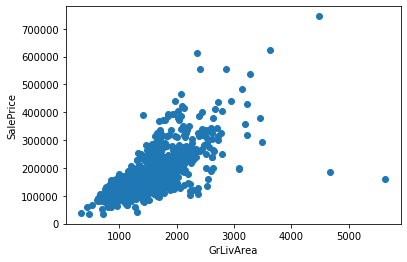

In [6]:
plt.scatter(train_dataset.df[['GrLivArea']], train_dataset.df[[target_column]])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")

## 1. Data Preprocessing

The features are at very different scales and variances. Therefore, we normalize the features ranges with the minimum and maximum value of each numeric column. For filling in missing numeric values (if any), we need the mean value. These values should be precomputed on the training set and used for all dataset splits. 

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
    <p>The <code>FeatureSelectorAndNormalizationTransform</code> class defined in <code>exercise_code/data/csv_dataset.py</code> is implementing this transformation. Make sure you have a look at the code of this file to understand the next cells. </p>
</div>

In [7]:
df = train_dataset.df
# Select a feature to keep plus the target column.
selected_columns = ['GrLivArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn

After having computed the ```min```, ```max``` and ```mean``` value, we load the data splits and perform the transformation on our data using the ```CSVDataset``` class. To check whether the partitions are correct, we print for each one of them the number of samples. Remember to not touch the test set until you are done with the training of your model.

In [8]:
# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


Let us load the respective data splits ('train', 'val, and 'test') into one matrix of shape $N \times D$ where $N$ represents the number of samples and $D$ the number of features (in our case we only have one feature). Similarly, we load the target data in one matrix.

In [9]:
# load training data into a matrix of shape (N, D), same for targets resulting in the shape (N, 1)
X_train = [train_dataset[i]['features'] for i in range((len(train_dataset)))]
X_train = np.stack(X_train, axis=0)
y_train = [train_dataset[i]['target'] for i in range((len(train_dataset)))]
y_train = np.stack(y_train, axis=0)
print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)

# load validation data
X_val = [val_dataset[i]['features'] for i in range((len(val_dataset)))]
X_val = np.stack(X_val, axis=0)
y_val = [val_dataset[i]['target'] for i in range((len(val_dataset)))]
y_val = np.stack(y_val, axis=0)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)

# load train data
X_test = [test_dataset[i]['features'] for i in range((len(test_dataset)))]
X_test = np.stack(X_test, axis=0)
y_test = [test_dataset[i]['target'] for i in range((len(test_dataset)))]
y_test = np.stack(y_test, axis=0)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape)


# 0 encodes small prices, 1 encodes large prices.

train data shape: (876, 1)
train targets shape: (876, 1)
val data shape: (292, 1)
val targets shape: (292, 1)
test data shape: (292, 1)
test targets shape: (292, 1)


In the following, we model our binary classification problem. We divide our target in the categories ```low-priced``` and ```expensive``` by labeling the 30% of the houses that are sold with the lowest price with ```0``` and, accordingly, the 30% of the houses with the highest price with ```1```. All other houses will be deleted from our data. We will use the  method ```binarize()```. For more information, take a look at the file ```networks/utils.py```.

In [10]:
from exercise_code.networks.utils import binarize
y_all = np.concatenate([y_train, y_val, y_test])
thirty_percentile = np.percentile(y_all, 30)
seventy_percentile = np.percentile(y_all, 70)

# Prepare the labels for classification.
X_train, y_train = binarize(X_train, y_train, thirty_percentile, seventy_percentile )
X_val, y_val   = binarize(X_val, y_val, thirty_percentile, seventy_percentile)
X_test, y_test  = binarize(X_test, y_test, thirty_percentile, seventy_percentile)

print("train data shape:", X_train.shape)
print("train targets shape:", y_train.shape)
print("val data shape:", X_val.shape)
print("val targets shape:", y_val.shape)
print("test data shape:", X_test.shape)
print("test targets shape:", y_test.shape)

train data shape: (533, 1)
train targets shape: (533, 1)
val data shape: (167, 1)
val targets shape: (167, 1)
test data shape: (177, 1)
test targets shape: (177, 1)


Obviously, we reduced our data and the remaining houses in our dataset are now either labeled with ```1``` and hence categorized as ```expensive```, or they are labeled with ```0``` and hence categorized as ```low-priced```.

The data is now ready and can be used to train our classifier model.